# Synthesis example: Classifying Viruses and Bacteria

Author: Adam Rivers

## Classifying sequences by their tetranucleotide frequencies

In this example we are going to classify Viral and Bacterial nucleotide sequences  using their tetranucleotide frequencies or 4-mers.

Kmers are counted by moving a sliding window of length (k=4) along a DNA sequence:

```
TCGGATTTTTAA
TCGA
 CGAT
  GATT
   ATTT
    TTTT
     TTTT
      TTTA
       TTAA
```

kmer | count | frequency
------|----- | --------
TCGA | 1 | 0.125
CGAT | 1 | 0.125
GATT | 1 | 0.125
ATTT | 1 | 0.125
TTTT | 2 | 0.250
TTTA | 1 | 0.125
TTAA | 1 | 0.125

## Selecting training data

To build a good classifier it is essential to sample training from a population representative of the population to be classified. This is a big challenge when working with sequencing data because the genomes that humans choose to sequence are not representative of the organisms in the environment.  We spend lots of time sequencing the organisms that make us sick.

This data has been carefully selected to take this into account.  We have selected about the same number of samples from every different family of bacteria and virus, then we extracted 5000 nucleotide long fragments from each genome.

## Information bleed over 

We know that we never want to evaluate our model using the training data. We always reserve a separate set of test data for evaluation. What happens though if some test data is almost exactly the same as our training data?  Let's say we have a Salmonella genome of the same type  in the test and the train sets? In this case we may artificially inflate the performance of our classifier. 

To avoid this issue in this example we have made sure that if an example is in the test set no organisms from that taxonomic family  are present in the test set. This gives us a realistic estimate of how well the classifier will perform at classifying a virus at the family level.


This is a common mistake in ML methods. Several papers have been published on this exact application that split data randomly or split test and training data by the date they were added to the RefSeq database.







## Logistic regression model
We will use these counts to classify the reads as viral or bacterial using a **_Logistic Regression_**. model (actually a type of classifier not a regressor).


First lets load in our testing and training data.


In [1]:
# Import pandas
import pandas as pd
import numpy as np
   
# Load in the raw data for bacteria
train_data_b = pd.read_csv("../nb-datasets/kmer/train/2.simple.csv.gz", header=None)
test_data_b = pd.read_csv("../nb-datasets/kmer/test/2.simple.csv.gz", header=None)

# add a label to indicate bacteria = 0 
train_data_b['label'] = 0
test_data_b['label'] = 0

# Load in the raw Training data for viruses
train_data_v = pd.read_csv("../nb-datasets/kmer/train/10239.simple.csv.gz", header=None)
test_data_v = pd.read_csv("../nb-datasets/kmer/test/10239.simple.csv.gz", header=None)

# add a label to indicate viruses = 1 
train_data_v['label'] = 1
test_data_v['label'] = 1

In [2]:

# combine the bacterial and viral data together
train_data = pd.concat([train_data_b, train_data_v])
test_data = pd.concat([test_data_b, test_data_v])

# Shuffle your training data. This is really important for methods that train in batches
train_data = train_data.sample(frac=1)
test_data = test_data.sample(frac=1)

# select just the features
train_data_x = train_data.iloc[:,1:257]
test_data_x = test_data.iloc[:,1:257]

# Normalize each row to a total of 1 by dividing each value by the sum
train_sum = train_data_x.sum(axis=1)
test_sum = test_data_x.sum(axis=1)
train_data_scaled=train_data_x.div(train_sum, axis=0)
test_data_scaled=test_data_x.div(test_sum, axis=0)


#view the training data
train_data_scaled.head()

,1,2,3,4,5,6,7,8,9,10,...,247,248,249,250,251,252,253,254,255,256
69219,0.007470,0.005667,0.006955,0.006054,0.004250,0.004894,0.003993,0.004122,0.004766,0.005796,...,0.004379,0.003993,0.004379,0.007599,0.008243,0.002447,0.005410,0.005410,0.007857,0.007470
15968,0.016311,0.005696,0.008026,0.015405,0.007767,0.002460,0.002848,0.005049,0.006731,0.004660,...,0.002201,0.005437,0.009450,0.004660,0.005049,0.005696,0.012168,0.007508,0.009450,0.016311
10833,0.018582,0.007066,0.009029,0.023423,0.008898,0.002748,0.003271,0.006281,0.010338,0.003010,...,0.001832,0.010338,0.009422,0.001832,0.004711,0.007590,0.020675,0.010861,0.007982,0.018582
83797,0.000903,0.001289,0.001418,0.001676,0.002063,0.002192,0.002837,0.001547,0.003353,0.005029,...,0.002450,0.003997,0.004255,0.003353,0.005287,0.002063,0.000387,0.002321,0.001676,0.000903
28788,0.013803,0.007482,0.008772,0.008901,0.007095,0.003483,0.004128,0.005547,0.008901,0.004128,...,0.001935,0.009417,0.006192,0.006579,0.005031,0.006192,0.009546,0.007482,0.008127,0.013803


In [3]:
#view the test data
test_data_scaled.head()

,1,2,3,4,5,6,7,8,9,10,...,247,248,249,250,251,252,253,254,255,256
2257,0.006289,0.004748,0.004748,0.003208,0.008727,0.002310,0.002053,0.003593,0.003850,0.005518,...,0.000257,0.004492,0.003593,0.006160,0.002053,0.007187,0.004492,0.003593,0.004492,0.006289
869,0.011138,0.003713,0.010370,0.005377,0.003329,0.004481,0.000768,0.003713,0.010882,0.005121,...,0.000896,0.008706,0.008450,0.002945,0.004481,0.004353,0.007041,0.006913,0.005505,0.011138
5978,0.005260,0.003720,0.006543,0.004362,0.005645,0.004233,0.002437,0.004362,0.006799,0.003335,...,0.002437,0.004875,0.007312,0.004618,0.006158,0.006543,0.003079,0.005645,0.005901,0.005260
3490,0.002696,0.004237,0.005649,0.003723,0.003852,0.006034,0.002311,0.002953,0.008345,0.003338,...,0.003723,0.007061,0.005392,0.003338,0.007446,0.004108,0.002824,0.005777,0.005007,0.002696
908,0.012390,0.006840,0.007357,0.014068,0.009938,0.002969,0.004388,0.004517,0.003872,0.003485,...,0.004259,0.004388,0.008647,0.004904,0.005808,0.008647,0.008518,0.009809,0.009938,0.012390


Take a look at the univariate distributions of some of the features

In [4]:
# Import plotting library Seaborn
import seaborn as sns
sns.set_style('darkgrid')

# plot some features (change the "3" to see more)
sns.distplot(train_data_scaled.iloc[:,3])

That's not very normal.  Let's see how our classifier performs. 

### Run the model

We will fit a logistic regression model with L1 regularization

In [5]:
from sklearn import linear_model

# convert our data into Numpy arrays 
X = train_data_scaled.to_numpy()
y = train_data["label"].to_numpy()

# Define the Logistic model parameters
model1 = linear_model.LogisticRegression(max_iter= 1000, random_state=0, solver='lbfgs', C=1)


# Fit the model (here's where the learning learning is happening) 

model1.fit(X, y)

# convert our test data into Numpy arrays
testX = test_data_scaled.to_numpy()
testy = test_data["label"].to_numpy()

# Estimate the accuracy
print("Test Accuracy: ")
model1.score(testX, testy) 

Test Accuracy: 


0.9191291481716339

That's pretty good accuracy, Remember though that our data is not a 50% split between viruses and bacteria. The test data has 16,175 bacteria and 7,480 viruses. If we made a classifier that just assigned everything the label of bacteria it would be have an accuracy of 

$$\frac{16175}{16175 + 7480} = 0.683$$

This is actually a common issue with using accuracy as a metric on imbalanced data. We will discuss better metrics soon.


## Transform the data

The next step is to try to normalize our data in a more sophisticated manner.

First think about 4-mers themselves. A few key insights are:

1. The total number of kmers does not matter since that just equals the sequence length (except in the accuracy of our frequency measurement).
2. The number of every kmer is affected by the number of every other kmer since kmers are mutually exclusive

These attributes describe **_compositional count data_**. Compositional data has an established set of transformations that can be used to move it into the real number space expected by most ML models.

The general steps are:

1. Close the dataset (make if sum to a constant, in our case 1)
2. Estimate the value of any 0's in count data as $\delta$, where $N$ is the number of components (256)

$$ \delta = \frac{1}{N^2} $$

4. Take the Centered log ratio. This value is the the log of the each component value divides by the geometric mean. 

    The geometric mean is:

$$ g(x) = \sqrt[D]{x_{1} \cdots x_{D}} $$

    The Centered log ratio is:
    
$$ \mathrm{clr}(x) = z = \left[ ln \frac{x_{1}}{g(x)}; \cdots; ln\frac{x_{1}}{g(x)} \right] $$ 




In [6]:
# import a subset of functions from  Scikit bio 
# (we have moved the functions to a new python file called comp.py for Windows compatability)

import comp

# First repalce any 0's with small values
train_z = comp.multiplicative_replacement(X)
test_z = comp.multiplicative_replacement(testX)

# Calculate a centered log ratio for each sample
train_clr = comp.clr(train_z)
test_clr = comp.clr(test_z)

train_clr

array([[ 0.75235042,  0.47609704,  0.68089146, ...,  0.42957703,
         0.80278127,  0.75235042],
       [ 1.72242674,  0.67033447,  1.01327922, ...,  0.94658784,
         1.17660427,  1.72242674],
       [ 2.21769592,  1.25085291,  1.49597537, ...,  1.68070947,
         1.37274273,  2.21769592],
       ...,
       [ 1.40508047,  0.77255791,  0.60193239, ...,  0.66937367,
         0.96786666,  1.40508047],
       [ 0.63687485,  0.57860594,  0.47324543, ...,  0.57860594,
         0.87127556,  0.63687485],
       [ 0.34464566,  0.16771495,  0.23023531, ..., -0.22174981,
         0.58387535,  0.34464566]])

Take a look at the univariate distributions of some of the features

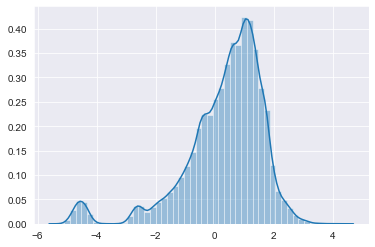

In [7]:
import seaborn as sns
sns.set_style('darkgrid')
sns.distplot(train_clr[:,3])

## Train the model again

Now evaluate the model with the transformed data


In [8]:
from sklearn import linear_model

# Create a new model
model2 = linear_model.LogisticRegression(max_iter= 1000, random_state=0, solver='lbfgs', C=1)

# Fit the model
model2.fit(train_clr, y)


# Estimate the accuracy
print("Accuracy :")
model2.score(test_clr, testy) 

Accuracy :


0.9330796871697316

93% Accuracy, we've improved our classifier by transforming the data
## Parameter tuning 

LEts look at the options you can specify when setting up a [logistic regression model in Scikit](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)


```{python}
class sklearn.linear_model.LogisticRegression(penalty=’l2’,
                                              dual=False,
                                              tol=0.0001, 
                                              C=1.0, 
                                              fit_intercept=True, 
                                              intercept_scaling=1, 
                                              class_weight=None, 
                                              random_state=None, 
                                              solver=’warn’, 
                                              max_iter=100, 
                                              multi_class=’warn’, 
                                              verbose=0, 
                                              warm_start=False, 
                                              n_jobs=None, 
                                              l1_ratio=None)
```

#### A couple of these are very important:
    
**`penalty`**: this controls for overfitting by **_regularization_**

There are two basic types of regularization l1 and l2.

* l1 (Lasso) regularization: drops some features out of the model
* l2 (Ridge) regularization: reduces the importance of some features with a weighting term

The parameter `C` controls how strongly the data should be regularized

* Smaller values of `c` mean stronger regularization.

We can find optimal settings for our dataset by trying multiple settings of parameters using the convenient function `LogisticRegressionCV`.  By setting `Cs=10` we specifying that the solver try 10 different values of C between 1e-4 and 1e4.  By setting a list of values for C we evaluate each value in the list.



In [9]:

model3 = linear_model.LogisticRegressionCV(Cs=[.01,.03,0.1,0.3,1, 3, 10],
                                          cv=5, 
                                          max_iter= 1000,
                                          random_state=0, 
                                          solver='lbfgs', 
                                          n_jobs=-1)

model3.fit(train_clr, y)

LogisticRegressionCV(Cs=[0.01, 0.03, 0.1, 0.3, 1, 3, 10], class_weight=None,
                     cv=5, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=1000,
                     multi_class='warn', n_jobs=-1, penalty='l2',
                     random_state=0, refit=True, scoring=None, solver='lbfgs',
                     tol=0.0001, verbose=0)

In [10]:
# Estimate the accuracy
print("Accuracy :")
model3.score(test_clr, testy)

Accuracy :


0.9330796871697316

In this case the parameter sweep did not improve the classifier the prediction.


# Classifier evaluation

Often it is useful to look at how the tradeoff between identfying a virus and 

Text(0.5, 1.0, '2-class Precision-Recall curve: F1=0.89')

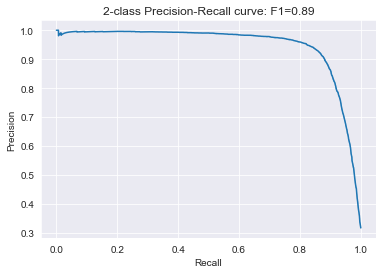

In [11]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


# Retrieve the scores from the logistic regression model
y_score = model3.decision_function(test_clr)
y_pred = model3.predict(test_clr)
# Calulate the aveage precision
f1 = f1_score(testy, y_pred)

precision, recall, _ = precision_recall_curve(testy, y_score)
sns.lineplot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('2-class Precision-Recall curve: F1={0:0.2f}'.format(f1))

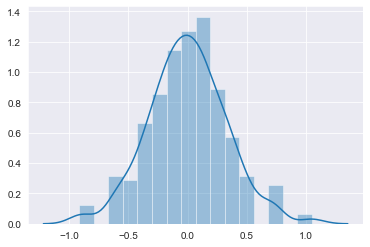

In [12]:
sns.distplot(model2.coef_)

## Predict the values for two real samples

Now let's predict the taxonomy for two viruses:
1. Ictalurid herpesvirus 2 strain 760/94 (A DNA virus)
2. Hubei picorna-like virus 82 strain from spider 133992 (A RNA virus)

In [13]:
# predict the taxonomy for two viruses 
seqs = np.array([[55.0,31.0,30.0,40.0,41.0,29.0,12.0,18.0,26.0,15.0,18.0,23.0,27.0,30.0,32.0,14.0,35.0,33.0,29.0,41.0,57.0,52.0,24.0,30.0,23.0,13.0,32.0,5.0,10.0,26.0,31.0,23.0,31.0,35.0,25.0,30.0,25.0,18.0,23.0,14.0,28.0,21.0,27.0,30.0,24.0,22.0,26.0,18.0,27.0,23.0,22.0,25.0,61.0,46.0,37.0,30.0,56.0,23.0,61.0,41.0,13.0,26.0,38.0,40.0,30.0,37.0,17.0,38.0,43.0,62.0,38.0,26.0,28.0,24.0,37.0,31.0,28.0,61.0,30.0,32.0,31.0,63.0,40.0,61.0,57.0,72.0,52.0,27.0,39.0,23.0,18.0,32.0,9.0,42.0,37.0,18.0,25.0,20.0,43.0,37.0,16.0,28.0,13.0,23.0,26.0,28.0,52.0,24.0,11.0,17.0,38.0,12.0,5.0,21.0,3.0,22.0,38.0,49.0,43.0,25.0,29.0,22.0,40.0,29.0,8.0,27.0,17.0,30.0,44.0,17.0,27.0,26.0,30.0,40.0,17.0,22.0,42.0,45.0,42.0,26.0,47.0,18.0,61.0,30.0,17.0,40.0,22.0,23.0,34.0,36.0,28.0,21.0,35.0,11.0,23.0,13.0,10.0,45.0,24.0,15.0,33.0,22.0,49.0,46.0,29.0,22.0,28.0,18.0,49.0,36.0,72.0,52.0,32.0,40.0,62.0,29.0,21.0,13.0,21.0,23.0,32.0,22.0,20.0,35.0,32.0,40.0,63.0,33.0,15.0,17.0,37.0,31.0,27.0,15.0,8.0,13.0,24.0,32.0,11.0,24.0,25.0,10.0,9.0,10.0,10.0,47.0,28.0,27.0,39.0,32.0,29.0,56.0,47.0,49.0,26.0,28.0,14.0,35.0,39.0,23.0,25.0,42.0,28.0,26.0,25.0,32.0,38.0,61.0,16.0,29.0,16.0,25.0,47.0,34.0,57.0,57.0,24.0,30.0,43.0,41.0,5.0,21.0,5.0,27.0,25.0,33.0,25.0,31.0,39.0,17.0,31.0,35.0,27.0,44.0,30.0,55.0],
                 [110.0,59.0,61.0,98.0,56.0,35.0,16.0,52.0,77.0,28.0,24.0,57.0,68.0,51.0,66.0,44.0,64.0,18.0,31.0,45.0,40.0,14.0,8.0,11.0,10.0,10.0,7.0,6.0,14.0,19.0,31.0,57.0,72.0,20.0,29.0,61.0,38.0,11.0,8.0,7.0,23.0,13.0,8.0,11.0,26.0,18.0,25.0,52.0,62.0,33.0,21.0,33.0,66.0,27.0,9.0,61.0,58.0,37.0,34.0,45.0,37.0,57.0,81.0,98.0,93.0,44.0,43.0,81.0,25.0,16.0,4.0,25.0,46.0,21.0,14.0,31.0,34.0,48.0,13.0,66.0,56.0,19.0,18.0,34.0,14.0,3.0,4.0,8.0,12.0,2.0,4.0,7.0,7.0,10.0,14.0,24.0,29.0,4.0,13.0,9.0,14.0,5.0,1.0,8.0,14.0,3.0,4.0,8.0,9.0,10.0,4.0,16.0,13.0,18.0,1.0,21.0,19.0,16.0,13.0,29.0,32.0,31.0,18.0,31.0,22.0,60.0,43.0,61.0,78.0,32.0,60.0,57.0,32.0,11.0,10.0,18.0,32.0,16.0,10.0,19.0,48.0,8.0,48.0,51.0,47.0,13.0,31.0,37.0,23.0,3.0,3.0,13.0,13.0,2.0,2.0,10.0,6.0,16.0,21.0,28.0,39.0,15.0,16.0,27.0,20.0,3.0,5.0,11.0,10.0,3.0,3.0,14.0,11.0,11.0,16.0,35.0,25.0,7.0,18.0,33.0,32.0,15.0,4.0,20.0,20.0,13.0,19.0,18.0,24.0,32.0,44.0,59.0,47.0,24.0,22.0,37.0,45.0,11.0,9.0,26.0,27.0,6.0,7.0,14.0,16.0,48.0,34.0,68.0,94.0,20.0,32.0,58.0,50.0,10.0,14.0,23.0,10.0,13.0,12.0,10.0,27.0,32.0,46.0,77.0,87.0,32.0,19.0,66.0,28.0,20.0,14.0,38.0,50.0,23.0,14.0,40.0,45.0,32.0,25.0,56.0,15.0,25.0,13.0,62.0,87.0,39.0,29.0,72.0,94.0,47.0,56.0,64.0,47.0,78.0,93.0,110.0]])

In [14]:
sample_z = comp.multiplicative_replacement(seqs)
sample_clr = comp.clr(sample_z)

model2.predict_proba(sample_clr)

array([[0.23416185, 0.76583815],
       [0.02445975, 0.97554025]])

The model classifies the herpesvirus as a virus with 76% probability.<br>
The model classifies the picronavirus as a virus with 98% probability.